The aim of this notebook is to use contrasting pairs of animal/non-animal related sentences to identify an "animal direction" in any of the layers in the residual stream of the last tokens of the sentences in a general model. 

In [1]:
import numpy as np
import random
import pandas as pd
import torch as t
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/Users/paul/anaconda3/envs/acd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Functions
def get_last_token_activations(sentences, model, tokenizer, device='cpu'):
    # Ensure the model and data are on the correct device
    model.to(device)
    
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output[0].detach()
        return hook

    # Register hooks to each layer of the model to capture activations
    hooks = [layer.register_forward_hook(get_activation(f'Layer_{i}')) for i, layer in enumerate(model.transformer.h)] # To do: Make more efficient by only including specified layer names

    # Tokenize and encode the sentences, then send to specified device
    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).to(device)
    
    # Perform model forward pass and prevent gradient computations
    with t.no_grad():
        model(**inputs)
    
    # Compute the index of the last non-padded token for each sentence
    last_token_indices = (inputs['attention_mask'].sum(dim=1) - 1).tolist()
    
    # Use advanced indexing to select the last token for each sentence in each layer
    last_token_activations = {}
    for key, val in activations.items():
        # Create a tensor of batch indices
        batch_indices = t.arange(val.size(0), device=device)
        # Index into the output for the last token of each sentence
        last_token_activations[key] = val[batch_indices, last_token_indices, :]
    
    # Clean up hooks after use to prevent memory leaks
    for hook in hooks:
        hook.remove()

    return last_token_activations

def compute_animal_directions(animal_sentences, non_animal_sentences, model, layer_names, tokenizer, device='cpu'):
    """
    Computes the direction vector (difference in means of activations) for animal vs. non-animal sentences
    across specified layers in a given model.

    Parameters:
    - animal_sentences (list of str): Sentences classified as 'animal'.
    - non_animal_sentences (list of str): Sentences classified as 'non-animal'.
    - model (torch.nn.Module): Model to compute activations from.
    - tokenizer (Tokenizer): Tokenizer that is compatible with the model.
    - device (str): Device to perform computations on ('cpu' or 'cuda').

    Returns:
    - dict: A dictionary with layer names as keys and direction vectors as values.
    """
    model.to(device)

    animal_activations = get_last_token_activations(animal_sentences, model, tokenizer)

    non_animal_activations = get_last_token_activations(non_animal_sentences, model, tokenizer)

    animal_directions = {}

    for layer_name in layer_names:
        animal_layer_activations = animal_activations[layer_name].cpu().numpy()
        non_animal_layer_activations = non_animal_activations[layer_name].cpu().numpy()
        animal_directions[layer_name] = np.mean(animal_layer_activations, axis=0) - np.mean(non_animal_layer_activations, axis=0)

    return animal_directions

def project_activations(activations, detector_direction):
    """
    Project activation vectors onto the detector direction.
    
    Parameters:
    - activations (numpy.ndarray): Activation vectors to project.
    - detector_direction (numpy.ndarray): The detector direction vector.
    
    Returns:
    - numpy.ndarray: Scalar values of the projection of each activation onto the detector direction.
    """

    # Project each activation onto the normalized detector direction
    projection = np.dot(activations, detector_direction)
    return projection

def calculate_accuracy(values, labels):
    """
    Calculate the accuracy of classification where positive numbers in 'values'
    should correspond to 1s in 'labels' and negative numbers to 0s.

    Parameters:
    - values (list of float): List of numerical values.
    - labels (list of int): Corresponding list of binary labels (1s and 0s).

    Returns:
    - float: The accuracy of the match-up, represented as a fraction between 0 and 1.
    """
    correct_count = 0
    total_count = len(values)

    for value, label in zip(values, labels):
        # Predict 1 if value is positive, 0 if negative
        predicted_label = 1 if value > 0 else 0
        # Check if prediction matches the label
        if predicted_label == label:
            correct_count += 1

    # Calculate accuracy
    accuracy = correct_count / total_count
    return accuracy

In [3]:
# Load the CSV file to verify it
df_sentences = pd.read_csv('../datasets/ilikecats_20000.csv')

# Display the first few entries
# print(df_sentences.head())

# Filter the DataFrame for rows where the Label column is 'Animal'. Shuffle.
animal_sentences = df_sentences[df_sentences['Label'] == 'Animal']['Sentence'].tolist()
non_animal_sentences = df_sentences[df_sentences['Label'] == 'Non-Animal']['Sentence'].tolist()

random.shuffle(animal_sentences)
random.shuffle(non_animal_sentences)

print(f"Animal sentences: {animal_sentences[0:3]}")
print(f"Non-animal sentences: {non_animal_sentences[0:3]}")



Animal sentences: ['I prefer rats.', 'I am annoyed by rats.', 'I strive for zebras.']
Non-animal sentences: ['I ask for economics.', 'I am scared of narratives.', 'I push for satellites.']


In [4]:
# Initialize the tokenizer and model #huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
# Set the EOS token as the padding token if it's not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
_ = model.eval()

In [5]:
# Compute animal direction for each layer

# Get layer names. Will depend on model!
layer_names = [f'Layer_{i}' for i in range(0,len(model.transformer.h))] # Max is range(len(model.transformer.h)

# Shorten samples, create train-test split

num_examples = 10000 # print(len(animal_sentences))

animal_sentences_short = animal_sentences[0:num_examples]
non_animal_sentences_short = non_animal_sentences[0:num_examples]

train_test_split = 0.8

train_animal_sentences = animal_sentences_short[0:int(num_examples*0.8)]
test_animal_sentences = animal_sentences_short[int(num_examples*0.8):]

train_non_animal_sentences = non_animal_sentences_short[0:int(num_examples*0.8)]
test_non_animal_sentences = non_animal_sentences_short[int(num_examples*0.8):]

# Compute activation directions

animal_directions = compute_animal_directions(train_animal_sentences, train_non_animal_sentences, model, layer_names, tokenizer)

Accuracy for Layer_0: 0.5
Accuracy for Layer_1: 0.5
Accuracy for Layer_2: 0.5
Accuracy for Layer_3: 0.6225
Accuracy for Layer_4: 0.86
Accuracy for Layer_5: 0.8225
Accuracy for Layer_6: 0.9225
Accuracy for Layer_7: 0.8375
Accuracy for Layer_8: 0.925
Accuracy for Layer_9: 0.9225
Accuracy for Layer_10: 0.8975
Accuracy for Layer_11: 0.88


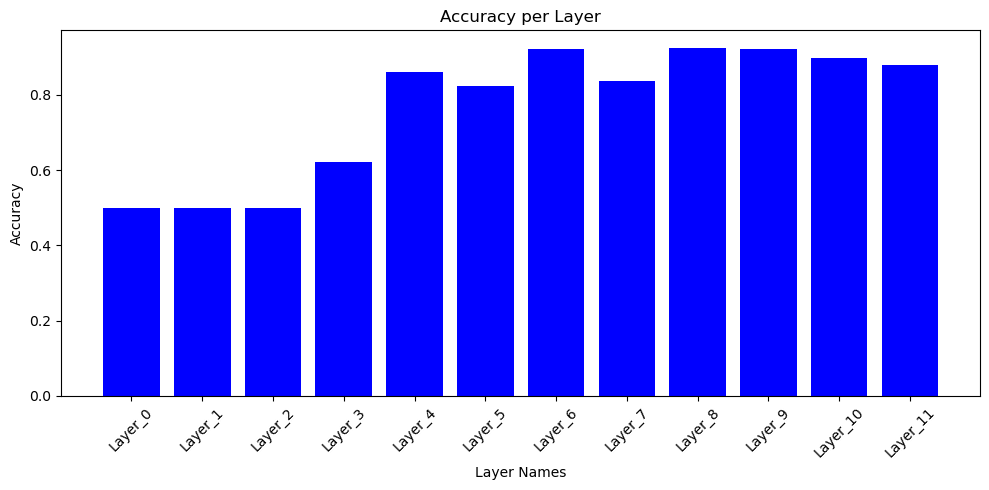

In [6]:
# Use test set to find values of projections of animanl and non-animal sentences onto animal directions.
# Plot accuracy
test_data = test_animal_sentences + test_non_animal_sentences
labels = [1]*len(test_animal_sentences) + [0]*len(test_non_animal_sentences)
test_activations = get_last_token_activations(test_data, model, tokenizer, device='cpu')

accuracies = {}

for layer_name in layer_names:
    results = project_activations(test_activations[layer_name], animal_directions[layer_name])
    accuracy = calculate_accuracy(results, labels)
    accuracies[layer_name] = accuracy
    print(f"Accuracy for {layer_name}:", accuracy)

# Plotting accuracies
plt.figure(figsize=(10, 5))
# layer_names_sorted = sorted(accuracies.keys())  # Optional: Sort layer names if needed
accuracy_values = [accuracies[name] for name in layer_names]
plt.bar(layer_names, accuracy_values, color='blue')
plt.xlabel('Layer Names')
plt.ylabel('Accuracy')
plt.title('Accuracy per Layer')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

In [23]:
# Run the experiment several times to check variance.

num_experiments = 5

results_of_experiments = []

for e in range(num_experiments):

    print(f"Experiment {e}")
    # Compute animal direction for each layer

    # Get layer names. Will depend on model!
    layer_names = [f'Layer_{i}' for i in range(0,len(model.transformer.h))] # Max is range(len(model.transformer.h)

    # Shorten samples, create train-test split

    # Filter the DataFrame for rows where the Label column is 'Animal'. Shuffle.
    animal_sentences = df_sentences[df_sentences['Label'] == 'Animal']['Sentence'].tolist()
    non_animal_sentences = df_sentences[df_sentences['Label'] == 'Non-Animal']['Sentence'].tolist()

    random.shuffle(animal_sentences)
    random.shuffle(non_animal_sentences)


    num_examples = 2000 # print(len(animal_sentences))

    animal_sentences_short = animal_sentences[0:num_examples]
    non_animal_sentences_short = non_animal_sentences[0:num_examples]

    train_test_split = 0.8

    train_animal_sentences = animal_sentences_short[0:int(num_examples*0.8)]
    test_animal_sentences = animal_sentences_short[int(num_examples*0.8):]

    train_non_animal_sentences = non_animal_sentences_short[0:int(num_examples*0.8)]
    test_non_animal_sentences = non_animal_sentences_short[int(num_examples*0.8):]

    # Compute activation directions

    animal_directions = compute_animal_directions(train_animal_sentences, train_non_animal_sentences, model, layer_names, tokenizer)

    # Use test set to find values of projections of animanl and non-animal sentences onto animal directions.
    # Plot accuracy
    test_data = test_animal_sentences + test_non_animal_sentences
    labels = [1]*len(test_animal_sentences) + [0]*len(test_non_animal_sentences)
    test_activations = get_last_token_activations(test_data, model, tokenizer, device='cpu')

    accuracies = {}

    for layer_name in layer_names:
        results = project_activations(test_activations[layer_name], animal_directions[layer_name])
        accuracy = calculate_accuracy(results, labels)
        accuracies[layer_name] = accuracy
        print(f"Experiment {e}. Accuracy for {layer_name}:", accuracy)
        results_of_experiments.append(accuracies)


Experiment 0
Experiment 0. Accuracy for Layer_0: 0.5
Experiment 0. Accuracy for Layer_1: 0.5
Experiment 0. Accuracy for Layer_2: 0.5
Experiment 0. Accuracy for Layer_3: 0.555
Experiment 0. Accuracy for Layer_4: 0.855
Experiment 0. Accuracy for Layer_5: 0.8225
Experiment 0. Accuracy for Layer_6: 0.93625
Experiment 0. Accuracy for Layer_7: 0.86625
Experiment 0. Accuracy for Layer_8: 0.9075
Experiment 0. Accuracy for Layer_9: 0.9125
Experiment 0. Accuracy for Layer_10: 0.86125
Experiment 0. Accuracy for Layer_11: 0.775
Experiment 1
Experiment 1. Accuracy for Layer_0: 0.5
Experiment 1. Accuracy for Layer_1: 0.5
Experiment 1. Accuracy for Layer_2: 0.5
Experiment 1. Accuracy for Layer_3: 0.67375
Experiment 1. Accuracy for Layer_4: 0.825
Experiment 1. Accuracy for Layer_5: 0.805
Experiment 1. Accuracy for Layer_6: 0.92625
Experiment 1. Accuracy for Layer_7: 0.82
Experiment 1. Accuracy for Layer_8: 0.89375
Experiment 1. Accuracy for Layer_9: 0.89
Experiment 1. Accuracy for Layer_10: 0.84625
Ex

In [15]:
print(results_of_experiments[0])

{'Layer_0': 0.5, 'Layer_1': 0.5, 'Layer_2': 0.5, 'Layer_3': 0.6975, 'Layer_4': 0.8525, 'Layer_5': 0.8225, 'Layer_6': 0.955, 'Layer_7': 0.855, 'Layer_8': 0.9325, 'Layer_9': 0.935, 'Layer_10': 0.8675, 'Layer_11': 0.8825}


In [24]:
# Initialize a dictionary to store all accuracies by layer
layer_accuracies = {}

# Loop through each experiment's dictionary in the list
for experiment in results_of_experiments:
    for layer, accuracy in experiment.items():
        if layer not in layer_accuracies:
            layer_accuracies[layer] = []
        layer_accuracies[layer].append(accuracy)


In [25]:
# Compute the mean accuracy for each layer
mean_accuracies = {layer: sum(acc_list) / len(acc_list) for layer, acc_list in layer_accuracies.items()}
# Compute the variance for each layer
variance_accuracies = {layer: sum((x - mean_accuracies[layer]) ** 2 for x in acc_list) / len(acc_list) for layer, acc_list in layer_accuracies.items()}

print(mean_accuracies)
print(variance_accuracies)

{'Layer_0': 0.5, 'Layer_1': 0.5, 'Layer_2': 0.5, 'Layer_3': 0.6122500000000006, 'Layer_4': 0.8552500000000002, 'Layer_5': 0.8259999999999994, 'Layer_6': 0.9344999999999989, 'Layer_7': 0.8437500000000004, 'Layer_8': 0.9030000000000004, 'Layer_9': 0.8977499999999996, 'Layer_10': 0.8572500000000006, 'Layer_11': 0.8352499999999999}
{'Layer_0': 0.0, 'Layer_1': 0.0, 'Layer_2': 0.0, 'Layer_3': 0.0022283749999999964, 'Layer_4': 0.0004639999999999999, 'Layer_5': 0.000365874999999999, 'Layer_6': 0.00010599999999999969, 'Layer_7': 0.0005943750000000001, 'Layer_8': 0.0002053749999999999, 'Layer_9': 0.00024274999999999956, 'Layer_10': 4.650000000000001e-05, 'Layer_11': 0.0011715000000000004}
